In [22]:
ls /home/gsm/Documents/extras/kaggle/petfinder/

breed_labels.csv  color_labels.csv  state_labels.csv  test/  train/


In [179]:
#cat /home/gsm/Documents/extras/kaggle/petfinder/state_labels.csv

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/home/gsm/Documents/extras/kaggle/petfinder/train/train.csv')
#drop_names = ['RescuerID','FurLength','Name','Color3']
#ddf = df.drop(columns=drop_names)

In [3]:
df.groupby('AdoptionSpeed').RescuerID.value_counts().unstack().max(axis=1)

AdoptionSpeed
0     12.0
1     52.0
2    173.0
3    223.0
4     90.0
dtype: float64

In [4]:
df.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3


In [5]:
#TODO clean up Descriptions nan's with  some imputer in text pipeline
df.Description.fillna('missing',inplace=True)

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import Binarizer,MinMaxScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder,QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import VotingClassifier


from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier,XGBRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score,make_scorer



In [60]:
class Pipeout(Pipeline):
    def predict(self,*args,**kwargs):
        yh = super(Pipeout,self).predict(*args,**kwargs)
        l = len(yh)
        d = dict(zip(range(l),yh))
        sorted_by_value = sorted(d.items(), key=lambda kv: kv[1])
        thrs = []
        cnt = 0
        for i,k in enumerate(sorted_by_value):
            if cnt<5 and i/l>rates[cnt]:
                cnt+=1
                thrs.append(k[1])
        #thrs.append(4)
        thrs = np.array(thrs)
        print(thrs)
        res = np.repeat(yh[np.newaxis,...], 4, axis=0) > np.repeat(thrs[np.newaxis,...], l, axis=0).T
        yt = res.sum(axis=0)
        return yt
        

In [214]:
#lgbm = LGBMClassifier(objective='multiclass',**params)
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'mse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1}
lgbm_c = LGBMClassifier()
lgbm_r = LGBMRegressor()#**params)
xgb_c = XGBClassifier(metric='cohen_kappa_score')
xgb_r = XGBRegressor()
vtc = VotingClassifier(estimators=[('dt',DTC()),('rf',RFC()),('lgbm',lgbm_c),('xgb',xgb_c)],voting='hard')

In [205]:
rates = (df.AdoptionSpeed.value_counts()/df.AdoptionSpeed.value_counts().sum()).values[::-1]
rates = np.cumsum(rates)

In [239]:
numeric_features = ['Sterilized','Age','Fee','PhotoAmt','VideoAmt']
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_features = ['State','Type','Breed1','Breed2','Gender','Health','Dewormed','Vaccinated']
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_features = 'Description'
text_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('bow', TfidfVectorizer(min_df=2,  max_features=None,
        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1,)),
    ('svd',TruncatedSVD(n_components=100))

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
        #('txt', text_transformer,text_features)],
    remainder='drop')

# clf = Pipeout(steps=[('preprocessor', preprocessor),
#                       ('classifier', vtc)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', vtc)])


clf.rates = rates

X = df.drop('AdoptionSpeed', axis=1)
y = df['AdoptionSpeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), ['Sterilized', 'Age', 'Fee', 'PhotoAmt', 'Vi...
       subsample=1))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None))])

In [240]:
yh = clf.predict(X_test)
#print("model score: %.3f" % clf.score(X_test, y_test))

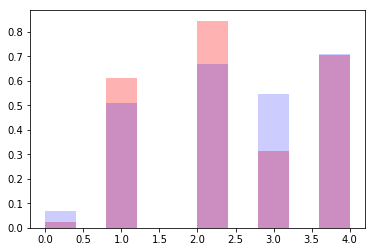

In [241]:
plt.hist(yh,normed=True,alpha=.3,color='r')
plt.hist(y_train,normed=True,alpha=.2,color='b');
#plt.hist(y_test,normed=True,alpha=.2,color='g');


In [242]:
cohen_kappa_score(y_test,yh,weights='quadratic')

0.35218914370642307

In [243]:
print(classification_report(yh,y_test))

              precision    recall  f1-score   support

           0       0.04      0.14      0.07        29
           1       0.39      0.35      0.37       733
           2       0.42      0.35      0.38      1014
           3       0.22      0.37      0.27       376
           4       0.56      0.52      0.54       847

   micro avg       0.40      0.40      0.40      2999
   macro avg       0.33      0.35      0.33      2999
weighted avg       0.42      0.40      0.41      2999



In [244]:
scorer = make_scorer(cohen_kappa_score,weights='quadratic')
score = cross_val_score(clf,X_test,y_test,cv=5,scoring=scorer)

In [245]:
score.mean(),score.std()*2

(0.33893565860464026, 0.09087306691776063)

In [246]:
score

array([0.38506686, 0.3813205 , 0.32852216, 0.34012979, 0.25963898])

In [132]:
sub_df = pd.DataFrame()
sub_df['PetID'] = X_test['PetID']
sub_df['AdoptionSpeed'] = yh
sub_df.to_csv('submission.csv', index=False)

In [203]:
#cat submission.csv